In [102]:
import statsmodels
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

<h1>Reading the data</h1>

In [103]:
data_file = '/Users/akira/soft/Qt Projects/rtqcm/data/21-01-11_long-temperature-drift-calibration-CrAu_data-3.csv'
data = pd.read_csv(data_file, parse_dates=['Time'], index_col = 'Time',dayfirst=True)
data.rename(columns={' Resistance ' : 'Resistance', ' Frequency' : 'Frequency'},inplace=True)
data.head()

,Frequency,Resistance
Time,,
2021-01-11 18:34:38.179540,5000103.0,330.87
2021-01-11 18:34:38.967539,5000103.0,330.87
2021-01-11 18:34:39.961968,5000103.0,330.87
2021-01-11 18:34:40.960428,5000103.0,330.87
2021-01-11 18:34:41.960690,5000103.0,330.87


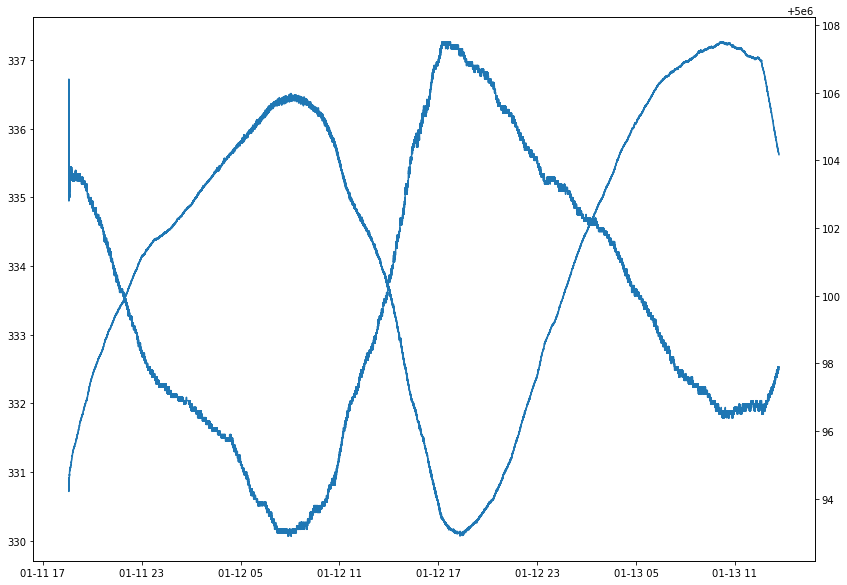

In [104]:
resistance = data['Resistance']
frequency = data['Frequency']
fig, ax = plt.subplots(figsize = (14,10))
ax2 = ax.twinx()
ax.plot(resistance)
ax2.plot(frequency)

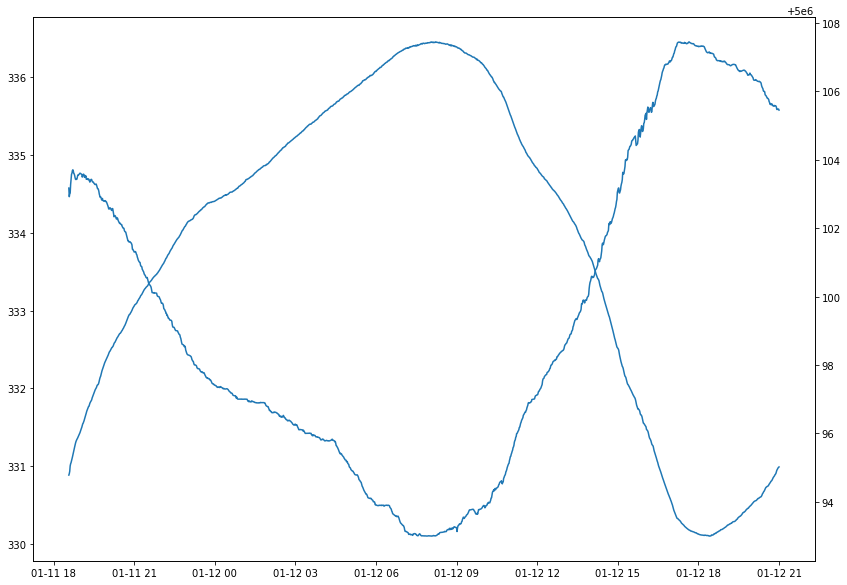

In [105]:
#Resample for the sake of demons
resampled = data.resample('1min').mean()[0:-1000]
resistance = resampled['Resistance']
frequency = resampled['Frequency']
fig, ax = plt.subplots(figsize = (14,10))
ax2 = ax.twinx()
ax.plot(resistance)
ax2.plot(frequency)

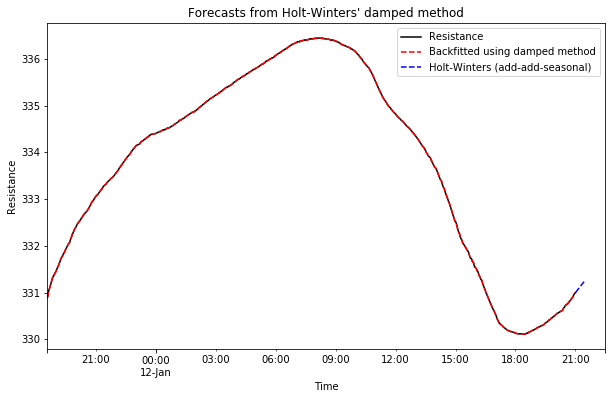

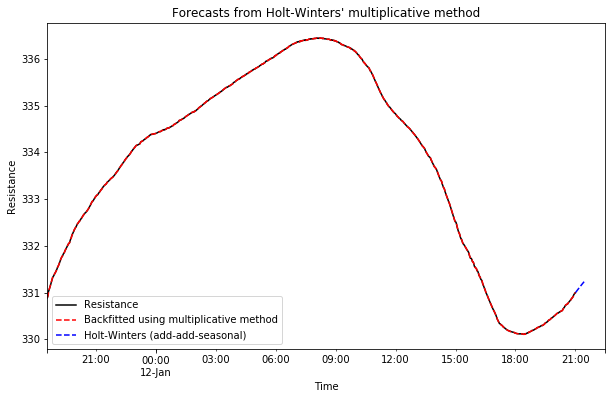

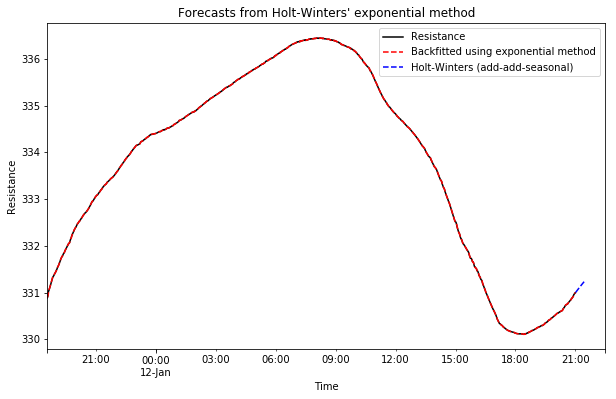

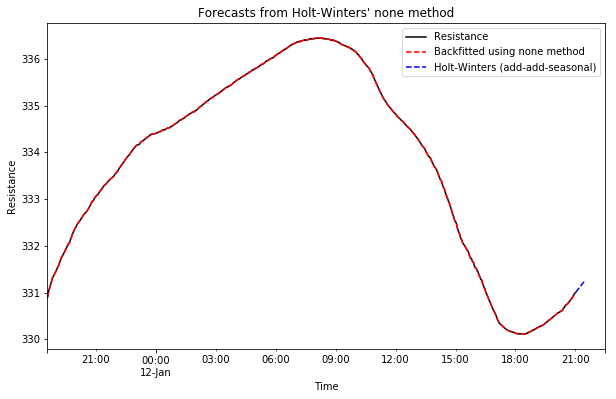

In [106]:
expForecasts = [
    ('damped' , ExponentialSmoothing(endog = resistance,trend='add', damped_trend = True, seasonal = None).fit()),
    ('multiplicative' , ExponentialSmoothing(endog = resistance,trend='add', damped_trend = True, seasonal = None).fit()),
    ('exponential' , ExponentialSmoothing(endog = resistance,trend='add', damped_trend = True, seasonal = None).fit()),
    ('none' , ExponentialSmoothing(endog = resistance,trend='add', damped_trend = True, seasonal = None).fit())
]
    
forecasted_minutes = 30
padding = 60

for fit in expForecasts:
    ax = resistance.plot(figsize=(10,6), color='black', title="Forecasts from Holt-Winters' {} method".format(fit[0]))
    ax.set_ylabel("Resistance")
    ax.set_xlabel("Time")
    fit[1].fittedvalues.plot(ax=ax, style='--', color='red', label = 'Backfitted using {} method'.format(fit[0]))
    fit[1].forecast(forecasted_minutes).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', color='blue', legend=True)
    plt.legend(loc='best')
    plt.xlim([resistance.index.values[0], resistance.index.values[-1] + np.timedelta64(forecasted_minutes + padding, 'm')])
    plt.show()




In [107]:
test = expForecasts[0][1]

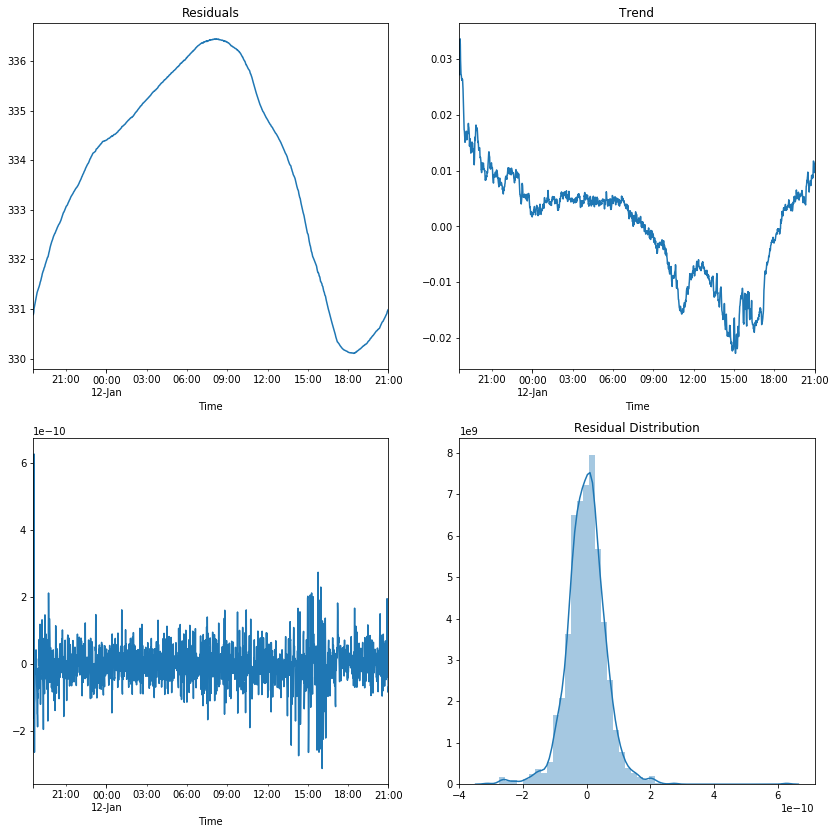

In [108]:
fig, axs = plt.subplots(2,2,figsize=(14,14))
test.level.plot(ax=axs[0,0])
axs[0,0].set_title('Level')
test.trend.plot(ax=axs[0,1])
axs[0,1].set_title('Trend')
residuals = resistance - test.level
residuals.plot(ax=axs[1,0])
axs[0,0].set_title('Residuals')
axs[1,1].set_title('Residual Distribution')
sns.distplot(residuals, ax=axs[1,1])


In [147]:
#For each 5 minutes time step after the initial sample gathering - make prediction for the 5 minutes and compare it to their real values and calculate the difference
def predict_compare(endog : pd.DataFrame, time_step : int, initial_sample_size : int):
    assert(len(endog) > initial_sample_size + time_step)
    steps = np.arange(initial_sample_size, len(endog), time_step).astype('int')
    total = steps[-1]
    forecasts = pd.DataFrame()
    for index,step in enumerate(steps):
        if(int(step*100/total)%10 == 0):
            print('{}% forecasted'.format(int(step*100/total)))
        current_sample_train = endog[:step]
        ExponentialSmoothing(endog = current_sample_train,trend='add', damped_trend = True, seasonal = None).fit()
        current_forecast = model.forecast(time_step)        
        forecasts = forecasts.append(pd.DataFrame(current_forecast.values,columns=['Resistance'], index=current_forecast.index))
    error = forecasts
    return error

In [146]:
error = predict_compare(endog=resistance, time_step=10, initial_sample_size=20)

[  20   30   40   50   60   70   80   90  100  110  120  130  140  150
  160  170  180  190  200  210  220  230  240  250  260  270  280  290
  300  310  320  330  340  350  360  370  380  390  400  410  420  430
  440  450  460  470  480  490  500  510  520  530  540  550  560  570
  580  590  600  610  620  630  640  650  660  670  680  690  700  710
  720  730  740  750  760  770  780  790  800  810  820  830  840  850
  860  870  880  890  900  910  920  930  940  950  960  970  980  990
 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130
 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270
 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410
 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550
 1560 1570 1580]
10% forecasted
10% forecasted
20% forecasted
20% forecasted
30% forecasted
40% forecasted
50% forecasted
50% forecasted
60% forecasted
60% forecasted
70% forecasted
70% forecasted
80% forecasted
90% for

In [148]:
forecasts

""


In [175]:
sr = test.forecast(10)
df = pd.DataFrame(columns = ['Resistance'])
df = df.append(pd.DataFrame(sr.values,columns=['Resistance'], index=sr.index))


In [176]:
df

,Resistance
2021-01-12 21:01:00,331.002324
2021-01-12 21:02:00,331.011933
2021-01-12 21:03:00,331.021493
2021-01-12 21:04:00,331.031006
2021-01-12 21:05:00,331.040472
2021-01-12 21:06:00,331.049890
2021-01-12 21:07:00,331.059261
2021-01-12 21:08:00,331.068585
2021-01-12 21:09:00,331.077863
2021-01-12 21:10:00,331.087094
